In [3]:
import zipfile
import os

# Define the path to your zip file and the directory where you want to extract it
zip_file_path = 'CWT_6sec.zip'  # Replace with your zip file path
extract_to_path = 'BCI'     # Replace with the path where you want to extract the files

# Ensure the extract directory exists
os.makedirs(extract_to_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files extracted to {extract_to_path}")


Files extracted to BCI


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Set up paths
data_dir = 'BCI/CWT_6sec'  # Update this to your dataset root path

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# Load dataset
# ImageFolder expects data directory with subdirectories for each class
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model (ResNet-20 is a variation of ResNet-18 for this example)
class ResNet20(nn.Module):
    def __init__(self, num_classes=4):  # Adjust number of classes if necessary
        super(ResNet20, self).__init__()
        self.model = resnet18(pretrained=False, num_classes=num_classes)
    
    def forward(self, x):
        return self.model(x)

model = ResNet20(num_classes=4)  # Adjust num_classes if you have a different number of classes

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation metrics storage
train_losses = []
test_accuracies = []
precisions = []
recalls = []
f1_scores = []

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Testing function
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store labels and predictions for precision, recall, and F1-score
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return correct / total, precision, recall, f1

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    accuracy, precision, recall, f1 = test(model, test_loader, device)
    
    # Store metrics
    train_losses.append(train_loss)
    test_accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Save the model
torch.save(model.state_dict(), 'resnet20_model.pth')
self.model.avgpool = nn.AdaptiveAvgPool2d((1, 1))

# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))

# Plot training loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, test_accuracies, 'r', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 3)
plt.plot(epochs, precisions, 'g', label='Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 4)
plt.plot(epochs, recalls, 'y', label='Recall')
plt.plot(epochs, f1_scores, 'm', label='F1 Score')
plt.title('Recall and F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\Rajveer\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Rajveer\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/100, Loss: 1.5021, Accuracy: 0.2693, Precision: 0.2669, Recall: 0.2693, F1-score: 0.2469
Epoch 2/100, Loss: 1.4103, Accuracy: 0.2475, Precision: 0.2478, Recall: 0.2475, F1-score: 0.2349
Epoch 3/100, Loss: 1.3959, Accuracy: 0.2614, Precision: 0.2876, Recall: 0.2614, F1-score: 0.1975
Epoch 4/100, Loss: 1.3773, Accuracy: 0.2436, Precision: 0.2400, Recall: 0.2436, F1-score: 0.1624
Epoch 5/100, Loss: 1.3686, Accuracy: 0.2198, Precision: 0.1710, Recall: 0.2198, F1-score: 0.1730
Epoch 6/100, Loss: 1.3536, Accuracy: 0.2515, Precision: 0.2515, Recall: 0.2515, F1-score: 0.2410
Epoch 7/100, Loss: 1.3293, Accuracy: 0.2317, Precision: 0.2258, Recall: 0.2317, F1-score: 0.2171
Epoch 8/100, Loss: 1.3025, Accuracy: 0.2475, Precision: 0.2636, Recall: 0.2475, F1-score: 0.2326
Epoch 9/100, Loss: 1.2594, Accuracy: 0.2376, Precision: 0.2210, Recall: 0.2376, F1-score: 0.2024
Epoch 10/100, Loss: 1.2185, Accuracy: 0.2277, Precision: 0.2340, Recall: 0.2277, F1-score: 0.2195
Epoch 11/100, Loss: 1.1319, A

KeyboardInterrupt: 

C:\Users\Rajveer\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Rajveer\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Rajveer\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/100, Loss: 1.5129, Accuracy: 0.2376, Precision: 0.1816, Recall: 0.2376, F1-score: 0.1444
Epoch 2/100, Loss: 1.4326, Accuracy: 0.2515, Precision: 0.2500, Recall: 0.2515, F1-score: 0.2023
Epoch 3/100, Loss: 1.4197, Accuracy: 0.2495, Precision: 0.2575, Recall: 0.2495, F1-score: 0.1686
Epoch 4/100, Loss: 1.3471, Accuracy: 0.2297, Precision: 0.2163, Recall: 0.2297, F1-score: 0.1900
Epoch 5/100, Loss: 1.3325, Accuracy: 0.2673, Precision: 0.2780, Recall: 0.2673, F1-score: 0.2006
Epoch 6/100, Loss: 1.3042, Accuracy: 0.2238, Precision: 0.2373, Recall: 0.2238, F1-score: 0.1920
Epoch 7/100, Loss: 1.2195, Accuracy: 0.2337, Precision: 0.4190, Recall: 0.2337, F1-score: 0.1444
Epoch 8/100, Loss: 1.1662, Accuracy: 0.2198, Precision: 0.2311, Recall: 0.2198, F1-score: 0.1940
Epoch 9/100, Loss: 1.0694, Accuracy: 0.2535, Precision: 0.2492, Recall: 0.2535, F1-score: 0.2340
Epoch 10/100, Loss: 0.9369, Accuracy: 0.2277, Precision: 0.2222, Recall: 0.2277, F1-score: 0.2130
Epoch 11/100, Loss: 0.7518, A

Epoch 85/100, Loss: 0.0512, Accuracy: 0.2614, Precision: 0.2617, Recall: 0.2614, F1-score: 0.2614
Epoch 86/100, Loss: 0.0737, Accuracy: 0.2634, Precision: 0.2657, Recall: 0.2634, F1-score: 0.2638
Epoch 87/100, Loss: 0.0786, Accuracy: 0.2594, Precision: 0.2540, Recall: 0.2594, F1-score: 0.2496
Epoch 88/100, Loss: 0.0976, Accuracy: 0.2277, Precision: 0.2277, Recall: 0.2277, F1-score: 0.2275
Epoch 89/100, Loss: 0.0456, Accuracy: 0.2515, Precision: 0.2595, Recall: 0.2515, F1-score: 0.2507
Epoch 90/100, Loss: 0.0997, Accuracy: 0.2574, Precision: 0.2507, Recall: 0.2574, F1-score: 0.2498
Epoch 91/100, Loss: 0.0911, Accuracy: 0.2515, Precision: 0.2484, Recall: 0.2515, F1-score: 0.2471
Epoch 92/100, Loss: 0.0456, Accuracy: 0.2317, Precision: 0.2338, Recall: 0.2317, F1-score: 0.2312
Epoch 93/100, Loss: 0.0317, Accuracy: 0.2376, Precision: 0.2406, Recall: 0.2376, F1-score: 0.2372
Epoch 94/100, Loss: 0.0622, Accuracy: 0.2356, Precision: 0.2384, Recall: 0.2356, F1-score: 0.2331
Epoch 95/100, Loss: 

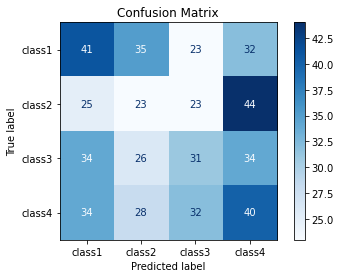

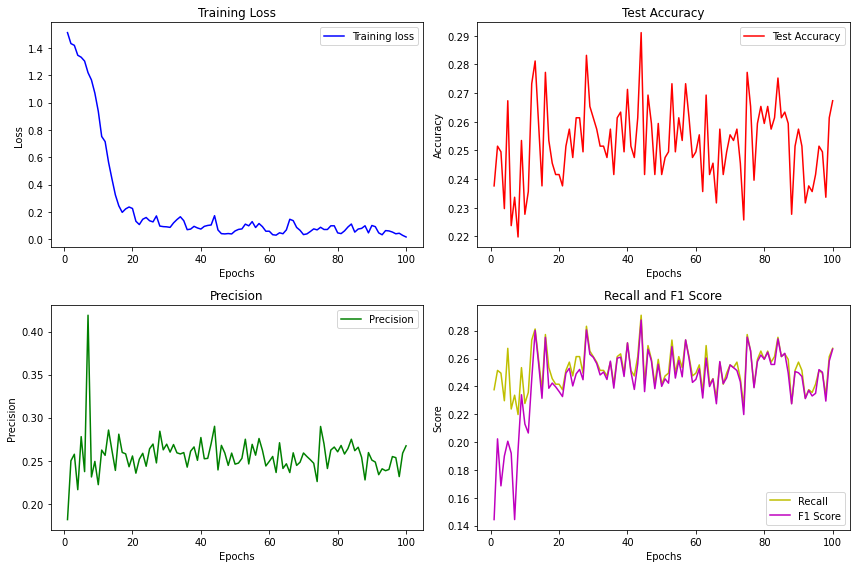

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set up paths
data_dir = 'BCI/CWT_6sec'  # Update this to your dataset root path

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset
# ImageFolder expects data directory with subdirectories for each class
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model (ResNet-20 is a variation of ResNet-18 for this example)
class ResNet20(nn.Module):
    def __init__(self, num_classes=4):  # Adjust number of classes if necessary
        super(ResNet20, self).__init__()
        self.model = resnet18(pretrained=False, num_classes=num_classes)
    
    def forward(self, x):
        return self.model(x)

model = ResNet20(num_classes=4)  # Adjust num_classes if you have a different number of classes

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation metrics storage
train_losses = []
test_accuracies = []
precisions = []
recalls = []
f1_scores = []

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Testing function
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store labels and predictions for precision, recall, and F1-score
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return correct / total, precision, recall, f1, conf_matrix

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    accuracy, precision, recall, f1, conf_matrix = test(model, test_loader, device)
    
    # Store metrics
    train_losses.append(train_loss)
    test_accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    
    # Plot confusion matrix after the last epoch
    if epoch == num_epochs - 1:
        disp = ConfusionMatrixDisplay(conf_matrix, display_labels=dataset.classes)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()

# Save the model
torch.save(model.state_dict(), 'resnet20_model.pth')

# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))

# Plot training loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, test_accuracies, 'r', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 3)
plt.plot(epochs, precisions, 'g', label='Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall and F1 score
plt.subplot(2, 2, 4)
plt.plot(epochs, recalls, 'y', label='Recall')
plt.plot(epochs, f1_scores, 'm', label='F1 Score')
plt.title('Recall and F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\Rajveer\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/100, Loss: 1.3912, Accuracy: 0.2158, Precision: 0.0467, Recall: 0.2158, F1-score: 0.0768


C:\Users\Rajveer\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/100, Loss: 1.3849, Accuracy: 0.2238, Precision: 0.2608, Recall: 0.2238, F1-score: 0.0962
Epoch 3/100, Loss: 1.3889, Accuracy: 0.2376, Precision: 0.3032, Recall: 0.2376, F1-score: 0.1651
Epoch 4/100, Loss: 1.3811, Accuracy: 0.2277, Precision: 0.2334, Recall: 0.2277, F1-score: 0.1808
Epoch 5/100, Loss: 1.3723, Accuracy: 0.2376, Precision: 0.1916, Recall: 0.2376, F1-score: 0.1904
Epoch 6/100, Loss: 1.3563, Accuracy: 0.2257, Precision: 0.2034, Recall: 0.2257, F1-score: 0.1422
Epoch 7/100, Loss: 1.3398, Accuracy: 0.2119, Precision: 0.2295, Recall: 0.2119, F1-score: 0.1861
Epoch 8/100, Loss: 1.3175, Accuracy: 0.2416, Precision: 0.2285, Recall: 0.2416, F1-score: 0.2115
Epoch 9/100, Loss: 1.2875, Accuracy: 0.2356, Precision: 0.2230, Recall: 0.2356, F1-score: 0.2255
Epoch 10/100, Loss: 1.2382, Accuracy: 0.2515, Precision: 0.2670, Recall: 0.2515, F1-score: 0.2341
Epoch 11/100, Loss: 1.2270, Accuracy: 0.2416, Precision: 0.2428, Recall: 0.2416, F1-score: 0.2364
Epoch 12/100, Loss: 1.1889, 

Epoch 86/100, Loss: 0.0659, Accuracy: 0.2554, Precision: 0.2647, Recall: 0.2554, F1-score: 0.2565
Epoch 87/100, Loss: 0.0702, Accuracy: 0.2455, Precision: 0.2669, Recall: 0.2455, F1-score: 0.2436
Epoch 88/100, Loss: 0.4031, Accuracy: 0.2614, Precision: 0.2644, Recall: 0.2614, F1-score: 0.2620
Epoch 89/100, Loss: 0.1508, Accuracy: 0.2475, Precision: 0.2527, Recall: 0.2475, F1-score: 0.2490
Epoch 90/100, Loss: 0.0817, Accuracy: 0.2594, Precision: 0.2750, Recall: 0.2594, F1-score: 0.2589
Epoch 91/100, Loss: 0.0608, Accuracy: 0.2436, Precision: 0.2515, Recall: 0.2436, F1-score: 0.2450
Epoch 92/100, Loss: 0.0591, Accuracy: 0.2495, Precision: 0.2571, Recall: 0.2495, F1-score: 0.2519
Epoch 93/100, Loss: 0.0598, Accuracy: 0.2574, Precision: 0.2600, Recall: 0.2574, F1-score: 0.2581
Epoch 94/100, Loss: 0.0380, Accuracy: 0.2475, Precision: 0.2649, Recall: 0.2475, F1-score: 0.2490
Epoch 95/100, Loss: 0.0838, Accuracy: 0.2574, Precision: 0.2715, Recall: 0.2574, F1-score: 0.2562
Epoch 96/100, Loss: 

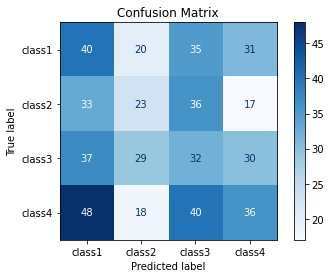

<Figure size 864x576 with 0 Axes>

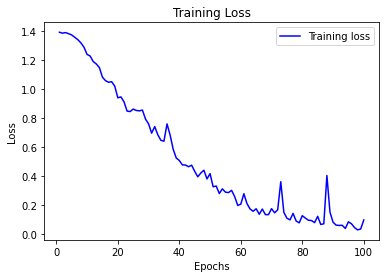

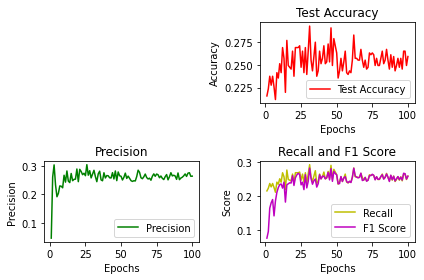

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set up paths
data_dir = 'BCI/CWT_6sec'  # Update this to your dataset root path

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=672, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Parameters for LSTM
input_size = 224  # Assuming each row of the image is a sequence element
hidden_size = 128
num_layers = 2
num_classes = 4  # Adjust this as needed

model = LSTMModel(input_size, hidden_size, num_layers, num_classes)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation metrics storage
train_losses = []
test_accuracies = []
precisions = []
recalls = []
f1_scores = []

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Reshape input for LSTM: flatten image to (batch_size, seq_len, input_size)
        inputs = inputs.view(inputs.size(0), 224, -1)  # Shape: [batch_size, 224, 224]
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Testing function
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Reshape input for LSTM
            inputs = inputs.view(inputs.size(0), 224, -1)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store labels and predictions for precision, recall, and F1-score
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return correct / total, precision, recall, f1, conf_matrix

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    accuracy, precision, recall, f1, conf_matrix = test(model, test_loader, device)
    
    # Store metrics
    train_losses.append(train_loss)
    test_accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    
    # Plot confusion matrix after the last epoch
    if epoch == num_epochs - 1:
        disp = ConfusionMatrixDisplay(conf_matrix, display_labels=dataset.classes)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()

# Save the model
torch.save(model.state_dict(), 'lstm_model.pth')

# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))

# Plot training loss
plt.figure()
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the figure at 300 DPI
plt.savefig('training_loss_plot.png', dpi=300)
plt.show()


# Plot test accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, test_accuracies, 'r', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 3)
plt.plot(epochs, precisions, 'g', label='Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall and F1 score
plt.subplot(2, 2, 4)
plt.plot(epochs, recalls, 'y', label='Recall')
plt.plot(epochs, f1_scores, 'm', label='F1 Score')
plt.title('Recall and F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/100, Loss: 1.3931, Accuracy: 0.2752, Precision: 0.2699, Recall: 0.2752, F1-score: 0.2703
Epoch 2/100, Loss: 1.3676, Accuracy: 0.2812, Precision: 0.2693, Recall: 0.2812, F1-score: 0.2698
Epoch 3/100, Loss: 1.3272, Accuracy: 0.2812, Precision: 0.2755, Recall: 0.2812, F1-score: 0.2722
Epoch 4/100, Loss: 1.2218, Accuracy: 0.2535, Precision: 0.2646, Recall: 0.2535, F1-score: 0.2531
Epoch 5/100, Loss: 1.0357, Accuracy: 0.2436, Precision: 0.2475, Recall: 0.2436, F1-score: 0.2441
Epoch 6/100, Loss: 0.8507, Accuracy: 0.2653, Precision: 0.2683, Recall: 0.2653, F1-score: 0.2639
Epoch 7/100, Loss: 0.6979, Accuracy: 0.2515, Precision: 0.2502, Recall: 0.2515, F1-score: 0.2505
Epoch 8/100, Loss: 0.5472, Accuracy: 0.2772, Precision: 0.2803, Recall: 0.2772, F1-score: 0.2717
Epoch 9/100, Loss: 0.4831, Accuracy: 0.2455, Precision: 0.2461, Recall: 0.2455, F1-score: 0.2435
Epoch 10/100, Loss: 0.4280, Accuracy: 0.2752, Precision: 0.2749, Recall: 0.2752, F1-score: 0.2736
Epoch 11/100, Loss: 0.3591, A

Epoch 85/100, Loss: 0.0001, Accuracy: 0.2950, Precision: 0.2964, Recall: 0.2950, F1-score: 0.2948
Epoch 86/100, Loss: 0.0001, Accuracy: 0.2950, Precision: 0.2964, Recall: 0.2950, F1-score: 0.2948
Epoch 87/100, Loss: 0.0001, Accuracy: 0.2911, Precision: 0.2927, Recall: 0.2911, F1-score: 0.2911
Epoch 88/100, Loss: 0.0001, Accuracy: 0.2911, Precision: 0.2927, Recall: 0.2911, F1-score: 0.2911
Epoch 89/100, Loss: 0.0001, Accuracy: 0.2911, Precision: 0.2927, Recall: 0.2911, F1-score: 0.2911
Epoch 90/100, Loss: 0.0001, Accuracy: 0.2911, Precision: 0.2927, Recall: 0.2911, F1-score: 0.2911
Epoch 91/100, Loss: 0.0001, Accuracy: 0.2911, Precision: 0.2928, Recall: 0.2911, F1-score: 0.2911
Epoch 92/100, Loss: 0.0001, Accuracy: 0.2931, Precision: 0.2947, Recall: 0.2931, F1-score: 0.2932
Epoch 93/100, Loss: 0.0000, Accuracy: 0.2911, Precision: 0.2927, Recall: 0.2911, F1-score: 0.2913
Epoch 94/100, Loss: 0.0000, Accuracy: 0.2931, Precision: 0.2946, Recall: 0.2931, F1-score: 0.2932
Epoch 95/100, Loss: 

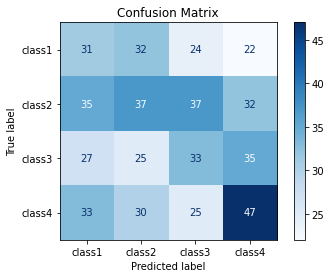

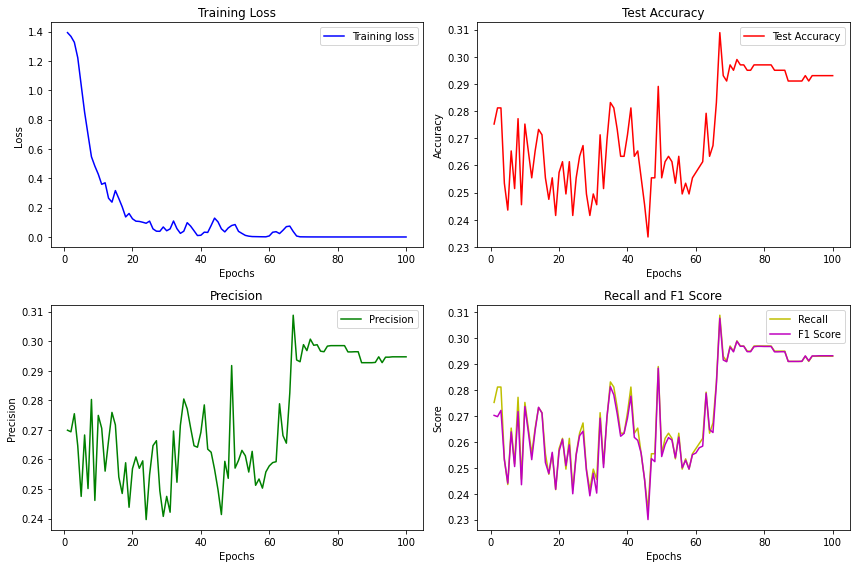

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Set up paths
data_dir = 'BCI/CWT_6sec'  # Update this to your dataset root path

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize PCA
pca = PCA(n_components=50)  # Reduce the dimensions to 50; adjust this based on your dataset

# Fit PCA on the training set
all_train_data = []
for inputs, _ in train_loader:
    # Reshape inputs to 2D (batch_size * 224, 224)
    inputs_reshaped = inputs.view(inputs.size(0) * 224, -1).numpy()
    all_train_data.append(inputs_reshaped)

all_train_data = np.concatenate(all_train_data, axis=0)
pca.fit(all_train_data)

# Function to apply PCA to the inputs
def apply_pca(inputs):
    batch_size = inputs.size(0)
    inputs_reshaped = inputs.view(batch_size * 224, -1).numpy()
    inputs_pca = pca.transform(inputs_reshaped)
    inputs_pca = torch.tensor(inputs_pca).view(batch_size, 224, -1)  # Shape [batch_size, 224, n_components]
    return inputs_pca

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Parameters for LSTM
input_size = 50  # Adjust this to the output dimension of PCA
hidden_size = 128
num_layers = 2
num_classes = 4  # Adjust this as needed

model = LSTMModel(input_size, hidden_size, num_layers, num_classes)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation metrics storage
train_losses = []
test_accuracies = []
precisions = []
recalls = []
f1_scores = []

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Apply PCA
        inputs = apply_pca(inputs).to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Testing function
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Apply PCA
            inputs = apply_pca(inputs).to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store labels and predictions for precision, recall, and F1-score
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return correct / total, precision, recall, f1, conf_matrix

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    accuracy, precision, recall, f1, conf_matrix = test(model, test_loader, device)
    
    # Store metrics
    train_losses.append(train_loss)
    test_accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    
    # Plot confusion matrix after the last epoch
    if epoch == num_epochs - 1:
        disp = ConfusionMatrixDisplay(conf_matrix, display_labels=dataset.classes)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()

# Save the model
torch.save(model.state_dict(), 'lstm_model_with_pca.pth')

# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))

# Plot training loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, test_accuracies, 'r', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 3)
plt.plot(epochs, precisions, 'g', label='Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall and F1 score
plt.subplot(2, 2, 4)
plt.plot(epochs, recalls, 'y', label='Recall')
plt.plot(epochs, f1_scores, 'm', label='F1 Score')
plt.title('Recall and F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Define the CNN-LSTM model
class CNN_LSTMModel(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes):
        super(CNN_LSTMModel, self).__init__()
        # Load a pre-trained CNN (ResNet)
        self.cnn = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # Remove the last FC layer
        self.cnn_output_size = 512  # Output size of the CNN

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size=self.cnn_output_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x):
        # Pass through CNN
        batch_size, seq_len, C, H, W = x.size()
        c_in = x.view(batch_size * seq_len, C, H, W)
        c_out = self.cnn(c_in).view(batch_size, seq_len, -1)
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(c_out, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Parameters for CNN-LSTM
hidden_size = 128
num_layers = 2
num_classes = 4  # Adjust this as needed

# Initialize the model
model = CNN_LSTMModel(hidden_size, num_layers, num_classes)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize PCA
pca = PCA(n_components=50)  # Reduce the dimensions to 50; you can adjust this

# Fit PCA on the training set with updated reshaping
def fit_pca(train_loader):
    all_train_data = []
    for inputs, _ in train_loader:
        # Reshape inputs to 2D (batch_size * C * H * W)
        batch_size, C, H, W = inputs.size()  # Assuming images have consistent size (C, H, W)
        inputs_reshaped = inputs.view(batch_size, -1).numpy()
        all_train_data.append(inputs_reshaped)
    all_train_data = np.concatenate(all_train_data, axis=0)
    pca.fit(all_train_data)

# Function to apply PCA to the inputs
def apply_pca(inputs):
    print(f"Original inputs size: {inputs.size()}")  # Debugging line
    
    # Check if inputs are 4D
    if len(inputs.size()) == 4:
        batch_size, C, H, W = inputs.size()
        inputs_reshaped = inputs.view(batch_size, -1).numpy()
        inputs_pca = pca.transform(inputs_reshaped)
        inputs_pca = torch.tensor(inputs_pca, dtype=torch.float32)  # Shape [batch_size, n_components]
    else:
        raise ValueError(f"Unexpected input dimensions: {inputs.size()}")

    return inputs_pca

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Add sequence dimension to match expected input shape of the model
        inputs = inputs.unsqueeze(1)  # Add sequence dimension: Shape [batch_size, seq_len=1, C, H, W]
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Add sequence dimension to match expected input shape of the model
            inputs = inputs.unsqueeze(1)  # Shape [batch_size, seq_len=1, C, H, W]
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store labels and predictions for precision, recall, and F1-score
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return correct / total, precision, recall, f1, conf_matrix


# Hyperparameters
learning_rate = 0.001
num_epochs = 50

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Ensure train_loader and test_loader are defined before proceeding
# Example:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Fit PCA on the training data
fit_pca(train_loader)

# Train the model
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

# Test the model
accuracy, precision, recall, f1, conf_matrix = test(model, test_loader, device)
print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')


C:\Users\Rajveer\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Rajveer\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 1.3890
Epoch [2/50], Loss: 1.3882
Epoch [3/50], Loss: 1.3876
Epoch [4/50], Loss: 1.3873
Epoch [5/50], Loss: 1.3863
Epoch [6/50], Loss: 1.3865
Epoch [7/50], Loss: 1.3865
Epoch [8/50], Loss: 1.3855
Epoch [9/50], Loss: 1.3857
Epoch [10/50], Loss: 1.3854
Epoch [11/50], Loss: 1.3852
Epoch [12/50], Loss: 1.3854
Epoch [13/50], Loss: 1.3860
Epoch [14/50], Loss: 1.3865
Epoch [15/50], Loss: 1.3856
Epoch [16/50], Loss: 1.3839
Epoch [17/50], Loss: 1.3851
Epoch [18/50], Loss: 1.3877
Epoch [19/50], Loss: 1.3877
Epoch [20/50], Loss: 1.3861
Epoch [21/50], Loss: 1.3873
Epoch [22/50], Loss: 1.3858
Epoch [23/50], Loss: 1.3859
Epoch [24/50], Loss: 1.3847
Epoch [25/50], Loss: 1.3865
Epoch [26/50], Loss: 1.3884
Epoch [27/50], Loss: 1.3869
Epoch [28/50], Loss: 1.3859
Epoch [29/50], Loss: 1.3854
Epoch [30/50], Loss: 1.3865
Epoch [31/50], Loss: 1.3859
Epoch [32/50], Loss: 1.3861
Epoch [33/50], Loss: 1.3843
Epoch [34/50], Loss: 1.3857
Epoch [35/50], Loss: 1.3878
Epoch [36/50], Loss: 1.3873
E

C:\Users\Rajveer\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
